In [31]:
import os
import time
import math
import scipy.io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle



In [2]:
from google.colab import drive 
drive.mount('/content/drive')

kmh = 20

Mounted at /content/drive


In [3]:
if kmh == 20:
  mat = scipy.io.loadmat('drive/MyDrive/KanalMedAPLseed2365.mat')
  mat = mat['channel_FD']
  channel11 = mat[0, 0].swapaxes(1,2)
  channel12 = mat[0, 1].swapaxes(1,2)
  channel21 = mat[1, 0].swapaxes(1,2)
  channel22 = mat[1, 1].swapaxes(1,2)
  subcarriers = channel11.shape[0]
  subcarriers = 200
  channel11 = channel11[:subcarriers]
  channel12 = channel12[:subcarriers]
  channel21 = channel21[:subcarriers]
  channel22 = channel22[:subcarriers]
  t = channel11.shape[1]*channel11.shape[2]
  MIMO = 4
  H = np.zeros([2*MIMO*subcarriers*t])
  H_noise = np.zeros_like(H)

  H[:subcarriers*2*t:2] = np.real(channel11.flatten())
  H[1:subcarriers*2*t:2] = np.imag(channel11.flatten())
  H[subcarriers*2*t:2*subcarriers*2*t:2] = np.real(channel12.flatten())
  H[subcarriers*2*t+1:2*subcarriers*2*t:2] = np.imag(channel12.flatten())
  H[2*subcarriers*2*t:3*subcarriers*2*t:2] = np.real(channel21.flatten())
  H[2*subcarriers*2*t+1:3*subcarriers*2*t:2] = np.imag(channel21.flatten())
  H[3*subcarriers*2*t:4*subcarriers*2*t:2] = np.real(channel22.flatten())
  H[3*subcarriers*2*t+1:4*subcarriers*2*t:2] = np.imag(channel22.flatten())
  H = H.astype(float)
  H = H.reshape([-1,1])
elif kmh == 3:
  mat = scipy.io.loadmat('drive/MyDrive/ChannelFD2Darrays.mat')
  channel11 = mat['channe11']
  channel12 = mat['channe12']
  channel21 = mat['channe21']
  channel22 = mat['channe22']
  subcarriers = channel11.shape[0]
  subcarriers = 200
  channel11 = channel11[:subcarriers]
  channel12 = channel12[:subcarriers]
  channel21 = channel21[:subcarriers]
  channel22 = channel22[:subcarriers]
  t = channel11.shape[1]
  MIMO = 4
  H = np.zeros([2*MIMO*subcarriers*t])
  H_noise = np.zeros_like(H)

  H[:subcarriers*2*t:2] = np.real(channel11.flatten())
  H[1:subcarriers*2*t:2] = np.imag(channel11.flatten())
  H[subcarriers*2*t:2*subcarriers*2*t:2] = np.real(channel12.flatten())
  H[subcarriers*2*t+1:2*subcarriers*2*t:2] = np.imag(channel12.flatten())
  H[2*subcarriers*2*t:3*subcarriers*2*t:2] = np.real(channel21.flatten())
  H[2*subcarriers*2*t+1:3*subcarriers*2*t:2] = np.imag(channel21.flatten())
  H[3*subcarriers*2*t:4*subcarriers*2*t:2] = np.real(channel22.flatten())
  H[3*subcarriers*2*t+1:4*subcarriers*2*t:2] = np.imag(channel22.flatten())
  H = H.astype(float)
  H = H.reshape([-1,1])

In [4]:
MIMO = 1

In [5]:
SNR_dB = 20
mat_noise = scipy.io.loadmat('drive/MyDrive/H_noise.mat')

In [6]:
if mat_noise['SNR_dB'] == 20:
  H_noisy = mat_noise['H_noise']
  H_noisy = H_noisy.reshape(-1,1)
else:
  var_H = np.var(H)
  var_noise = var_H/(10**(SNR_dB/10))
  H_noisy = np.random.normal(size=H.shape, scale=np.sqrt(var_noise))
  scipy.io.savemat('drive/MyDrive/H_noise.mat', {'SNR_dB': SNR_dB, 
                                                 'H_noise': H_noisy})

In [7]:
#H_noisy = np.zeros_like(H_noisy)

In [8]:
# Get to operate for both train and test dataset

def dataset_MIMO(dataset, noisy_dataset, step, lookback=4, samples=100000, model_type='GRU', offset=0, horizon=0, past=0): 
  h = int(horizon/step)
  horizon = horizon-step

  # Define lookback period and split inputs/labels
  #subcarriers = 624 # Already defined above
  sc = math.ceil(samples/(t-lookback*step))

  if sc <= subcarriers:
    inputs = np.zeros((sc*(t-lookback*step), lookback, 2*MIMO))
    labels = np.zeros((sc*(t-lookback*step), past+h, 2*MIMO))
    labels_clean = np.zeros((sc*(t-lookback*step), past+h, 2*MIMO))

  else: 
    while sc <= subcarriers:
      samples = samples*subcarriers/sc
      sc = math.ceil(samples/(t-lookback*step))
      
    print('Observe that the number of data points available in this setting are ' + str(samples))
    inputs = np.zeros((samples, lookback, 2*MIMO))
    labels = np.zeros((samples, past+h, 2*MIMO))
    labels_clean = np.zeros((samples, past+h, 2*MIMO))

  jump = 20
  for i in range(0, sc*jump, jump):
      p = 2*t*(i+offset) # To jump to the current subcarrier
      for j in range(2*lookback*step, 2*t, 2):     
        for m in range(MIMO):

          q = 2*subcarriers*t*m # To jump to the current antenna array (MIMO)
          s = q+p+j-(2*lookback*step) # First index for retrieving data. The current position minus the lookback
          e = q+p+j # Last index for retrieving data

          c = int(i/jump)*(t-lookback*step) + int(j/2)-lookback*step # The current position to store data

          inputs[c, :, 2*m] = dataset[s:e:2*step].reshape(lookback) + noisy_dataset[s:e:2*step].reshape(lookback)
          inputs[c, :, 2*m+1] = dataset[s+1:e+1:2*step].reshape(lookback) + noisy_dataset[s+1:e+1:2*step].reshape(lookback)
          
          labels_clean[c, :, 2*m] = dataset[e-2*past*step:e+2*horizon+2:2*step,0]#.reshape(-1,1+past+h,2) #::ts_step , past*step
          labels_clean[c, :, 2*m+1] = dataset[e-2*past*step+1:e+2*horizon+2+1:2*step,0]#.reshape(-1,1+past+h,2) #::ts_step , past*step
          labels[c, :, 2*m] = noisy_dataset[e-2*past*step:e+2*horizon+2:2*step,0] + dataset[e-2*past*step:e+2*horizon+2:2*step,0]#.reshape(-1,1+past+h,2)
          labels[c, :, 2*m+1] = noisy_dataset[e-2*past*step+1:e+2*horizon+2+1:2*step,0] + dataset[e-2*past*step+1:e+2*horizon+2+1:2*step,0]#.reshape(-1,1+past+h,2)

  inputs = inputs[:samples]
  labels = labels[:samples]
  labels_clean = labels_clean[:samples]



  return inputs, labels, labels_clean

In [9]:
def scaler_transform(X_list):#, x_max, x_min):
  if type(X_list) == list:
    X_scaled = []
    for X in X_list:
      X_scaled.append((X-x_min)/(x_max-x_min))
  else:
    X_scaled = (X_list[0]-x_min)/(x_max-x_min)
    
  return X_scaled
  

def scaler_inv_transform(X_list):#, x_max, x_min):
  if type(X_list) == list:
    X_std = []
    for X in X_list:
      X_std.append(X * (x_max-x_min)+x_min)
      
  else:
    X_std = X_list * (x_max-x_min)+x_min
    
  return X_std

In [10]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [11]:
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        #pe = torch.zeros(max_seq_len, 1, d_model)
        pe = torch.zeros(max_seq_len, d_model)

        #pe[:, 0, 0::2] = torch.sin(position * div_term)
        #pe[:, 0, 1::2] = torch.cos(position * div_term)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        #pe = torch.zeros(1, max_seq_len, d_model)
        #pe[0, :, 0::2] = torch.sin(position * div_term)
        #pe[0, :, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        
        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [12]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        max_seq_len: int,
        out_seq_len: int=1,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=2*MIMO
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            batch_first=batch_first,
            max_seq_len=max_seq_len
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

In [13]:
def get_src_trg(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        target_seq_len: int
        ): #-> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        #print("Called dataset.TransformerDataset.get_src_trg")
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        #print("From data.TransformerDataset.get_src_trg: sequence shape: {}".format(sequence.shape))

        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]

        #print("From data.TransformerDataset.get_src_trg: trg shape before slice: {}".format(trg.shape))

        trg = trg[:, 0]

        #print("From data.TransformerDataset.get_src_trg: trg shape after slice: {}".format(trg.shape))

        if len(trg.shape) == 1:

            trg = trg.unsqueeze(-1)

            #print("From data.TransformerDataset.get_src_trg: trg shape after unsqueeze: {}".format(trg.shape))

        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape before slice: {}".format(trg_y.shape))

        # We only want trg_y to consist of the target variable not any potential exogenous variables
        trg_y = trg_y[:, 0]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape after slice: {}".format(trg_y.shape))

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

In [14]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

In [15]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
        #self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.tanh(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
          
        return hidden

In [16]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.tanh(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [17]:
def train(model, train_loader, model_type='regular'):
    model.train()
    train_loss = 0

    if model_type in ['GRU', 'LSTM']:
      h = model.init_hidden(batch_size)
      for x, label, clean_label in train_loader:
          optimizer.zero_grad()
          out, _ = model(x.to(device).float(), h)
          loss = criterion(out, label.to(device).float())
          loss.backward()#retain_graph=True)
          optimizer.step()
          loss = criterion(torch.from_numpy(scaler_inv_transform(out.cpu().detach().numpy())), 
                           torch.from_numpy(clean_label.numpy()))
          train_loss += loss.item()


    elif model_type == 'TRANS':
      for x, label, clean_label in train_loader:
        optimizer.zero_grad()
        src = x[:,:enc_seq_len,:]
        tgt = x[:,-dec_seq_len:,:]
        out = model(src.to(device).float(), tgt.to(device).float(), src_mask=src_mask.to(device).float(), tgt_mask=tgt_mask.to(device).float())
        loss = criterion(out, label.to(device).float())
        loss.backward()#retain_graph=True)
        optimizer.step()
        loss = criterion(torch.from_numpy(scaler_inv_transform(out.cpu().detach().numpy()))[:,-1,:], 
                         torch.from_numpy(clean_label.numpy())[:,-1,:])
        train_loss += loss.item()

    else: 
      for i, data in enumerate(train_loader, 0):
          x, label, clean_label = data
          optimizer.zero_grad()
          out = model(x.to(device).float())
          loss = criterion(out, label.to(device).float())
          loss.backward()
          optimizer.step()
          loss = criterion(torch.from_numpy(scaler_inv_transform(out.cpu().detach().numpy())), 
                           torch.from_numpy(clean_label.numpy()))
          train_loss += loss.item()

    optimizer.zero_grad()

    return train_loss/len(train_loader)

In [33]:
def evaluate(model, test_x, test_y_clean, test_y, model_type, epoch):
    model.eval()
    start_time = time.time()
    inp = torch.from_numpy(test_x)
    target = torch.from_numpy(test_y_clean)
    labs_dist = torch.from_numpy(test_y)
    target_measured = scaler_inv_transform(labs_dist.numpy())

    if (model_type == 'GRU' or model_type == 'LSTM'):
      h = model.init_hidden(inp.shape[0])
      start_time = time.time()
      out, _ = model(inp.to(device).float(), h)
      stop_time = time.time()

    elif model_type == 'TRANS':
      src = inp[:,:enc_seq_len,:]
      tgt = inp[:,-dec_seq_len:,:]
      start_time = time.time()
      out = model(src.to(device).float(), tgt.to(device).float(), src_mask=src_mask.to(device).float(), tgt_mask=tgt_mask.to(device).float())
      stop_time = time.time()

    else:
      start_time = time.time()
      out = model(inp.to(device).float())
      stop_time = time.time()
    
    eval_time = stop_time - start_time
    print(eval_time)

    output = scaler_inv_transform(out.cpu().detach().numpy())
    loss = criterion(torch.from_numpy(output)[:,-1,:], 
                     target[:,-1,:])
    test_loss = loss.item()

    target = target.numpy()
    # NMSE in dB
    nmse_db = 10*np.log10(np.mean((np.linalg.norm(target-output, axis=1)**2)/(np.linalg.norm(target,axis=1)**2)))
    
    if epoch == 150 and model_type == 'GRU':
      pred_test = pd.DataFrame(np.append(output.T, target.T, axis=0).T, columns=['Predicted channel Re(1)', 'Predicted channel Im(1)', 
                                                                                 'True channel Re(1)', 'True channel Im(1)',])
      df1 = pd.DataFrame()
      df1['Prederr1'] = (pred_test['Predicted channel Re(1)']-pred_test['True channel Re(1)'])
      df1['ImagPrederr1'] = (pred_test['Predicted channel Im(1)']-pred_test['True channel Im(1)'])
      df2 = pd.DataFrame(df1.values.reshape(-1,1), columns=['Err'+str(i)])
      df2.to_csv('drive/MyDrive/prediction_err_snr' + str(i) + '.csv')

    if 0:#epoch%3 == 0:
      # Plot channel tracker
      a = 400
      b = 800
      step = 1
      font = 18
      #Validation data
      #fig, ax = plt.subplots(figsize=[10, 8])
      #ax.tick_params(labelsize=10)
      #plt.plot(target_measured[a:b+a, 0], target_measured[a:b+a, 1], label='true channel noisy')
      plt.plot(target_measured[a:b+a:step, 0], target_measured[a:b+a:step, 1], label='Measured channel')
      plt.plot(output[a:b+a:step, 0], output[a:b+a:step, 1], label='predicted channel', c='r')
      plt.plot(target[a:b+a:step, 0], target[a:b+a:step, 1], label='true channel', c='black')
      plt.xlabel('Real part', fontsize=font)
      plt.ylabel('Imaginary part', fontsize=font)
      plt.legend(fontsize=10)
      plt.yticks(fontsize=font)
      plt.show()

    #print("Evaluation Time: {}".format(str(time.time()-start_time)))
    #sMAPE = np.mean(abs(output-target)/(abs(target)+abs(output))/2)
    #L1Loss = np.mean(abs(output-target))#**2)
    #print("MSE: {}".format(loss))

    optimizer.zero_grad()
    
    return test_loss, nmse_db

In [19]:
def epoch_loop(model, train_loader, test_x, test_y, test_y_clean, epochs, lr_scheduler1, model_type = 'GRU'):
  print('Started with ' + model_type)

  training_loss = np.zeros([epochs])
  validation_loss = np.zeros([epochs])
  nmse_db = 100
  start_time = time.time()
  best_loss = 1



  for epoch in range(1,epochs+1):
    training_loss[epoch-1] = train(model, train_loader, model_type)
    validation_loss[epoch-1], nmse_db1 = evaluate(model, test_x, test_y_clean, test_y, model_type, epoch)

    if nmse_db1 < nmse_db:
      nmse_db = nmse_db1

    if 1:#epoch%10 == 0:
      current_time = time.time()
      print("Epoch {}/{} Done".format(epoch, epochs))
      print("Total Time Elapsed: %.2f minutes" %((current_time-start_time)/60))
      print("Training loss: %.6f " %(training_loss[epoch-1]))
      print("Validation loss: %.6f " %(validation_loss[epoch-1]))

    # save best model: here we save the model only for the lowest validation loss
    #if validation_loss[epoch] < best_loss:
    #    # Save model parameters
    #    torch.save({'model': model.state_dict()}, 'model' + model_type + '.pth') 
    #    # Update best validation loss
    #    best_loss = validation_loss[epoch]
    #    # statement
    #    print('Model saved')
      
    if lr_scheduler1:
      #print('step')
      lr_scheduler1.step()

  return training_loss, validation_loss, nmse_db

In [20]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [21]:
# TODO implement predictions for different horizons based on n previous samples without different steplengths.
# TODO test a model trained with ue speed 20kmh on dataset with ue speed 3 kmh
# TODO histogram over MSE for all horizons of GRU test predictions
# TODO plot loss as function of lookback
# COMPLETE run with test set from other subcarrier
# COMPLETE let MLP and CNN have the same "complexity" as the RNN algorithms

SNR_dB = 20
lr_trans = 0.00008
ts_step = np.array([14])
horizons = np.array([14])#, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 196, 210])
train_samples = 90000
test_samples = 10000
samples = 100000
test_sc_offset = 100
batch_size = 32 #32
epochs = 50
criterion = nn.MSELoss()

file = 'drive/MyDrive/performance_SNR20_horizon_nM_test.csv'
if os.path.isfile(file): # Add functionality for skipping if performance df is full
  performance_df = pd.read_csv(file, index_col=0)
  cols = list(performance_df.columns)
  if len(performance_df.index) is not len(horizons):
    mask = np.isin(horizons, np.array(performance_df.index))
    diff = horizons[np.invert(mask)]
    for d in diff:
      performance_df.loc[d] = np.zeros(len(cols))
else:
  performance_df = pd.DataFrame(columns=['Outdated', 'MLP', 'CNN', 'GRU', 'LSTM', 'Transformer'], index=horizons)
  for col in performance_df.columns:
    performance_df[col].values[:] = 0

file_nmse = 'drive/MyDrive/nmse_SNR20_horizon_nM_test.csv'
if os.path.isfile(file_nmse): # Add functionality for skipping if performance df is full
  nmse_df = pd.read_csv(file_nmse, index_col=0)
  cols = list(nmse_df.columns)
  if len(nmse_df.index) is not len(horizons):
    mask = np.isin(horizons, np.array(nmse_df.index))
    diff = horizons[np.invert(mask)]
    for d in diff:
      nmse_df.loc[d] = np.zeros(len(cols))
else:
  nmse_df = pd.DataFrame(columns=['GRU', 'LSTM', 'CNN', 'MLP', 'Transformer'], index=horizons)
  for col in nmse_df.columns:
    nmse_df[col].values[:] = 0


In [22]:
training_loss_transformer =   np.zeros([len(horizons), epochs])
validation_loss_transformer = np.zeros([len(horizons), epochs])
nmse_transformer = np.zeros([len(horizons)])

In [23]:
## Model parameters
dim_val = 128 #256 #512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 #8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 1# 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 1# 4 # Number of times the decoder layer is stacked in the decoder
input_size = 2*MIMO # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 5 #4 # test 25 # length of input given to encoder. Can have any integer value.
dec_seq_len = 2 #2 # test 5 # length of input given to decoder. Can have any integer value.
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoderdropout_encoder: float=0.2, 

In [34]:
# Implement more decoder sequences

for i in range(len(horizons)):
    output_sequence_length = int(horizons[i]/ts_step[0]) # Length of the target sequence, i.e. how many time steps should your forecast cover
    # Creating dataset
    train_x, train_y, train_y_clean = dataset_MIMO(H, H_noisy, ts_step[0], enc_seq_len, train_samples, 'TRANS', horizon=horizons[i], past=dec_seq_len-output_sequence_length)
    test_x, test_y, test_y_clean = dataset_MIMO(H, H_noisy, ts_step[0], enc_seq_len, test_samples, 'TRANS', test_sc_offset, horizon=horizons[i], past=dec_seq_len-output_sequence_length)
    X = np.append(np.append(train_x, test_x), np.append(train_y, test_y))
    x_max = np.max(X)
    x_min = np.min(X)
    [train_x, train_y] = scaler_transform([train_x, train_y])
    [test_x, test_y] = scaler_transform([test_x, test_y])
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y), torch.from_numpy(train_y_clean))
    train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True, shuffle = False)
    # Transfomers
    if 1:
      criterion = nn.MSELoss()
      ## Model parameters
      
      
      # Make src mask for decoder with size:
      tgt_mask = generate_square_subsequent_mask(
          dim1=dec_seq_len, #output_sequence_length,
          dim2=dec_seq_len, #output_sequence_length
         )
      src_mask = generate_square_subsequent_mask(
          dim1=dec_seq_len, #output_sequence_length,
          dim2=enc_seq_len # Check memory mask and padding
          )

      trans_model = TimeSeriesTransformer(
      dim_val=dim_val,
      input_size=input_size, 
      dec_seq_len=dec_seq_len,
      batch_first=True,
      max_seq_len=max_seq_len,
      out_seq_len=output_sequence_length, 
      n_decoder_layers=n_decoder_layers,
      n_encoder_layers=n_encoder_layers,
      n_heads=n_heads,
      dropout_encoder=0.1, 
      dropout_decoder=0.1,
      dropout_pos_enc=0.1,
      dim_feedforward_encoder=512,#1024,
      dim_feedforward_decoder=512)#)

      trans_model.to(device)

      pp=0
      for p in list(trans_model.parameters()):
        fn=1
        for s in list(p.size()):
            fn = fn*s
        pp += fn
      print(pp)

      optimizer = torch.optim.Adam(trans_model.parameters(), lr=lr_trans)
      lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(np.arange(start=10, stop=140, step=5)), gamma=0.8)
      optimizer = torch.optim.Adam(trans_model.parameters(), lr=lr_trans)
      training_loss_transformer[i, :], validation_loss_transformer[i, :], nmse_transformer[i] = epoch_loop(trans_model, train_loader, test_x, test_y, test_y_clean, 
                                                                                                           epochs, lr_scheduler, model_type = 'TRANS')
      performance_df.loc[horizons[i], 'Transformer'] = min(validation_loss_transformer[i, :])
      performance_df.to_csv(file)
      nmse_df.loc[horizons[i], 'Transformer'] = nmse_transformer[i]
      nmse_df.to_csv(file_nmse)

    train_y = train_y[:,-1,:]
    train_y_clean = train_y_clean[:,-1,:]
    test_y = test_y[:,-1,:]
    test_y_clean = test_y_clean[:,-1,:]

    # Outdated
    if 0:#not performance_df.loc[horizons[i], 'Outdated']:
      performance_df.loc[horizons[i], 'Outdated'] = np.mean(abs(scaler_inv_transform(test_x[:, -2*MIMO:])-test_y_clean)**2)
      performance_df.to_csv(file)
      NMSE = (np.linalg.norm(scaler_inv_transform(test_x[:, -2*MIMO:])-test_y_clean, axis=1)**2)/(np.linalg.norm(test_y_clean, axis=1)**2)
      nmse_df.loc[horizons[i], 'Outdated'] = 10*np.log10(np.mean(NMSE))
      nmse_df.to_csv(file_nmse)

    print('Sampling time ' + str(horizons[i]/14) + ' ms done.')

463874
Started with TRANS
0.003131866455078125
Epoch 1/50 Done
Total Time Elapsed: 0.40 minutes
Training loss: 0.277403 
Validation loss: 0.035725 


KeyboardInterrupt: ignored

In [ ]:
performance_df

,Outdated,MLP,CNN,GRU,LSTM,Transformer
14,0.018543,0,0,0.005914,0,0.025068


#Evalutation on training data

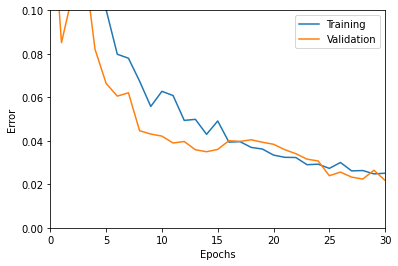

In [ ]:
p = 0
fig, ax = plt.subplots()
plt.plot(training_loss_transformer[p], label='Training')
plt.plot(validation_loss_transformer[p], label='Validation')
#plt.plot(training_loss_lstm, label='LSTM')
#plt.plot(training_loss_mlp, label='MLP_training')
#plt.plot(validation_loss_mlp, label='MLP_validation')
#plt.plot(training_loss_cnn, label='CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
#plt.axvline(np.where(validation_loss_gru[p] == min(validation_loss_gru[p])), c='black')
ax.set_ylim([0,0.1])
ax.set_xlim([0, 30])
plt.show()

#Evaluation on test data

In [ ]:
# Predict channel with gru model for test data
inp = torch.from_numpy(np.array(test_x))
src = inp[:,:enc_seq_len,:]
tgt = inp[:,-dec_seq_len:,:]
labs_dist = torch.from_numpy(np.array(test_y))
labs_clean = torch.from_numpy(np.array(test_y_clean))
#out = torch.zeros([inp.shape[0], inp.shape[2]])


In [ ]:
#for i in range(inp.shape[0]):
#  out[i] = trans_model(src[i].reshape(1,src.shape[1], src.shape[2]).to(device).float(), tgt[i].reshape(1, tgt.shape[1], tgt.shape[2]).to(device).float(), src_mask=src_mask.to(device).float(), tgt_mask=tgt_mask.to(device).float())
out = trans_model(src.to(device).float(), tgt.to(device).float(), src_mask=src_mask.to(device).float(), tgt_mask=tgt_mask.to(device).float())
output_test = scaler_inv_transform(out[:,-1,:].cpu().detach().numpy())#.reshape(-1)
#output_test = out.cpu().detach().numpy()
#target_test = scaler_inv_transform(labs_clean.numpy())
target_test = labs_clean.numpy()
target_measured = scaler_inv_transform(labs_dist.numpy())

In [ ]:
out.shape

torch.Size([1000, 5, 2])

In [ ]:
# Save predictions for test set
pred_test = pd.DataFrame(np.append(np.append(output_test.T, target_test.T, axis=0), target_measured.T, axis=0).T, 
                         columns=['Predicted channel Re(1)', 'Predicted channel Im(1)', 
                                  'True channel Re(1)', 'True channel Im(1)',
                                  'Measured channel Re(1)', 'Measured channel Im(1)'])

pred_test.to_csv('drive/MyDrive/prediction_snr_test1.csv')

In [ ]:
df1 = pd.DataFrame()
df1['Prederr1'] = (pred_test['Predicted channel Re(1)']-pred_test['True channel Re(1)'])
df1['Prederr2'] = (pred_test['Predicted channel Re(2)']-pred_test['True channel Re(2)'])
df1['Prederr3'] = (pred_test['Predicted channel Re(3)']-pred_test['True channel Re(3)'])
df1['Prederr4'] = (pred_test['Predicted channel Re(4)']-pred_test['True channel Re(4)'])
df1['ImagPrederr1'] = (pred_test['Predicted channel Im(1)']-pred_test['True channel Im(1)'])
df1['ImagPrederr2'] = (pred_test['Predicted channel Im(2)']-pred_test['True channel Im(2)'])
df1['ImagPrederr3'] = (pred_test['Predicted channel Im(3)']-pred_test['True channel Im(3)'])
df1['ImagPrederr4'] = (pred_test['Predicted channel Im(4)']-pred_test['True channel Im(4)'])

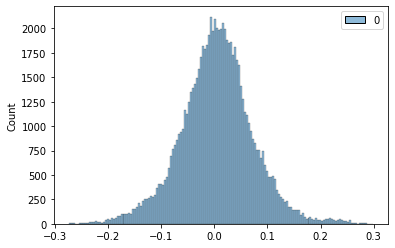

In [ ]:
sns.histplot(data=df2)#, cumulative=True)

In [ ]:
np.mean((target_measured[1:]-target_test[:-1])**2)

0.005011336333325963

In [ ]:
np.mean((target_measured-target_test)**2)

0.004941112595238321

In [ ]:
np.mean((output_test-target_test)**2)

0.009095690156476856

In [ ]:
np.mean((output_test-target_measured)**2)

0.014070102503479962

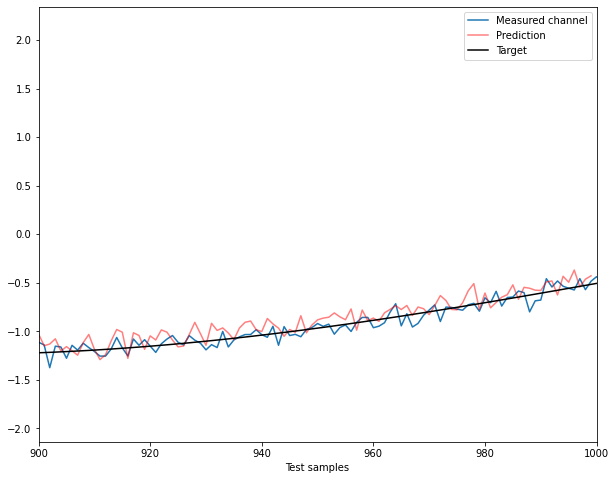

In [ ]:
#Validation data
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(target_measured[:, 1], label='Measured channel')
plt.plot(output_test[:, 1], label='Prediction', c='red', alpha=0.5)
plt.plot(target_test[:, 1], label='Target', c='black')
#plt.plot(20+np.linspace(0,len(ma_test),len(ma_test)), ma_test, label='Target', c='purple')
plt.legend()
plt.xlim([900, 1000])
#plt.ylim([-0.9, -0.2])
plt.xlabel('Test samples')
plt.show()

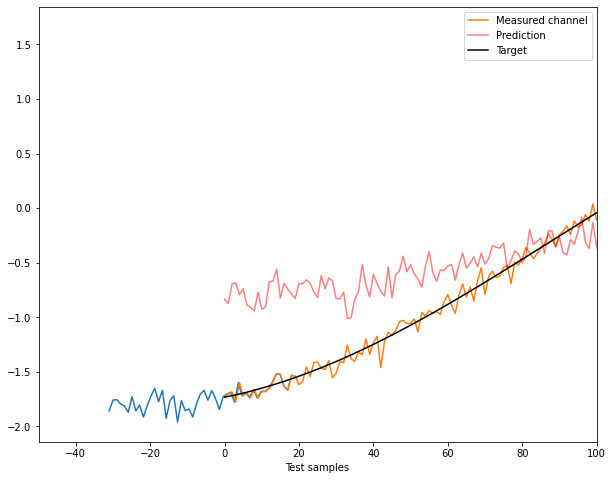

In [ ]:
#Validation data
M = 1
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(np.linspace(-31, 19), sc.inverse_transform(test_x[20,: ,M].reshape(-1,1)))
plt.plot(target_measured[:, M], label='Measured channel')
plt.plot(output_test[:, M], label='Prediction', c='red', alpha=0.5)
plt.plot(target_test[:, M], label='Target', c='black')
#plt.plot(20+np.linspace(0,len(ma_test),len(ma_test)), ma_test, label='Target', c='purple')
plt.legend()
plt.xlim([-50, 100])
#plt.ylim([-0.9, -0.2])
plt.xlabel('Test samples')
plt.show()

In [ ]:
print(target_test[0, 0])
print(target_test[0, 1])
print(output_test[0, 0])
print(output_test[0, 1])

0.2782929837703705
1.5625143051147459
0.122781746
1.5785087


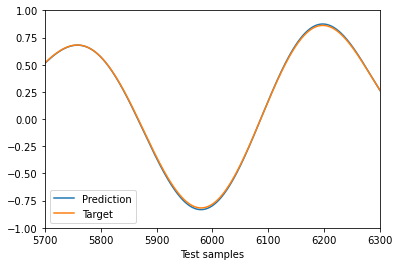

In [ ]:
#Validation data
plt.plot(output_test[:, 0], label='Prediction')
plt.plot(target_test[:, 0], label='Target')
plt.legend()
plt.xlim([5700, 6300])
plt.ylim([-1.0, 1.0])
plt.xlabel('Test samples')
plt.show()

In [ ]:
target_measured[:-1, c][-1]

0.07182231906449153

In [ ]:
target_measured[:, c][-1]

-0.0036327738416374305

In [ ]:
c=1
print(np.mean((target_measured[:-1, c]-target_test[1:, c])**2))

0.004894085096240301


In [ ]:
np.mean((target_measured[:, c]-target_test[:, c])**2)

0.0047858979097917045

In [ ]:
np.mean((output_test[:, c]-target_test[:, c])**2)

0.006745950423091992

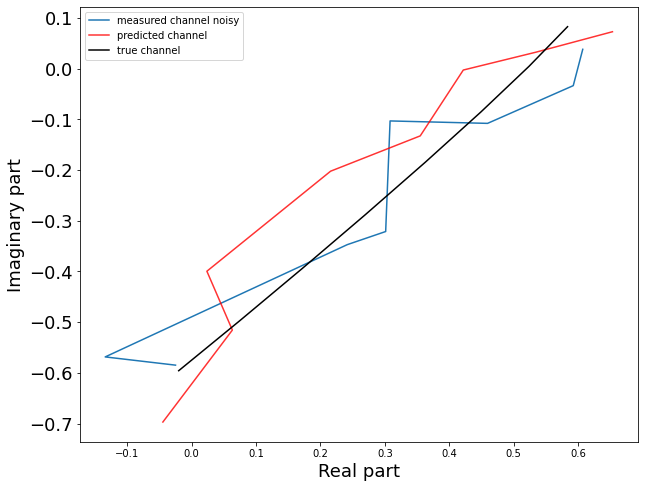

In [ ]:
# Plot channel tracker
#a = 5000
#b = 1000
a = 450
b = 100
step = 14
font = 18
#Validation data
fig, ax = plt.subplots(figsize=[10, 8])
ax.tick_params(labelsize=10)
plt.plot(target_measured[a:b+a:step, 0], target_measured[a:b+a:step, 1], label='measured channel noisy')
plt.plot(output_test[a:b+a:step, 0], output_test[a:b+a:step, 1], label='predicted channel', c='r', alpha=0.8)
plt.plot(target_test[a:b+a:step, 0], target_test[a:b+a:step, 1], label='true channel', c='black')

#plt.scatter((output_test[a, 0]+target_test[a, 0])/2, (output_test[a, 1]+target_test[a, 1])/2, label='sequence start', c='g', s=100)
#plt.scatter((output_test[b-1+a, 0]+target_test[b-1+a, 0])/2, (output_test[b-1+a, 1]+target_test[b-1+a, 1])/2, label='sequence stop', c='r', s=100)
#plt.xlim([0.575, 0.6])
#plt.ylim([1, 1.5])

plt.xlabel('Real part', fontsize=font)
plt.ylabel('Imaginary part', fontsize=font)
#plt.legend(fontsize=10)
#plt.xticks([-2,-1, 0, 1, 2], fontsize=font)
#plt.xlim([-2,2])
plt.yticks(fontsize=font)
plt.legend()

plt.show()

Text(0.5, 0, 'Test samples')

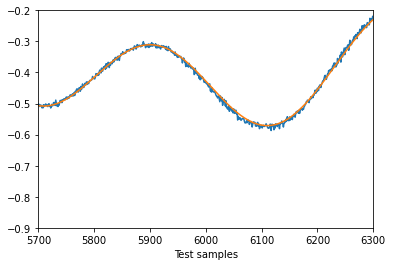

In [ ]:
#Validation data
plt.plot(output_test[:, 0])
plt.plot(target_test[:, 0])
plt.xlim([5700, 6300])
plt.ylim([-0.9, -0.2])
plt.xlabel('Test samples')
#plt.legend(['output_real_1', 'target_real_1'])#, 'target_real_3', 'target_imag_3', 'target_real_4', 'target_imag_4'])

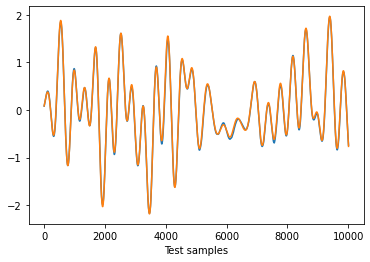

In [ ]:
#Validation data
plt.plot(opt[:,0])
plt.plot(tgt[:,0])
#plt.xlim([4000, 5000])
#plt.ylim([-2.2, -1.9])
plt.xlabel('Test samples')
#plt.legend(['output_real_1', 'target_real_1'])#, 'target_real_3', 'target_imag_3', 'target_real_4', 'target_imag_4'])
plt.show()

Text(0, 0.5, 'MSE')

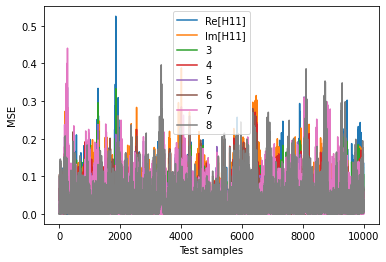

In [ ]:
# Plot absolute prediction errors for all antenna arrays
lo = plt.plot(abs(output_test-target_test)**2)
plt.legend(lo, ('Re[H11]', 'Im[H11]', '3', '4', '5', '6', '7', '8'))
plt.plot()
#plt.xlim([3450, 3525])
#plt.ylim([0, 0.005])
plt.xlabel('Test samples')
plt.ylabel('MSE')

Text(0, 0.5, 'Frequency')

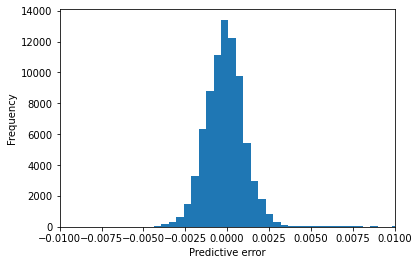

In [ ]:
# Histogram for the absolute prediction error
plt.hist((output_test-target_test).flatten(), 90)
plt.xlim([-0.01, 0.01])
plt.xlabel('Predictive error')
plt.ylabel('Frequency')

#Test for dataset generating process

In [ ]:
# Initializations for tests below
lookback=4
step = 1
t=42000
inputs, labels = dataset_MIMO(70, 4, 100000)

In [ ]:
# Test
# To see if function dataset_MIMO works properly. (Not MLP)
train_x1, train_y1, test_x1, test_y1 = dataset_MIMO(3, lookback, samples, 'GRU')
test1 = train_y1[(t-lookback)*2]
check = np.array([])
for m in range(MIMO*2) :
  check = np.append(check, train_x1[(t-lookback)*2+step, lookback-1, m])

np.array_equal(check, test1)


In [ ]:
# Test
# To see if function dataset_MIMO works properly. (MLP)
train_x, train_y, test_x, test_y = train_test_split(inputs, labels, 'MLP')
test2 = train_y[(t-lookback)*2]
check = train_x[(t-lookback)*2+1, -8:]
np.array_equal(check, test2)

In [ ]:
# Loading the best model
ckpt = torch.load('model2.pth', map_location=lambda storage, loc: storage)
best_model = GRUNet(8, hidden[0], 8, 3)
best_model.load_state_dict(ckpt['model'])
# put model on device
best_model.to(device=device)